# VOC Data Analysis

This notebook contains the analysis of three VOC datasets to showcase analytical capabilities.

## Load Libraries

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import KFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score

import shap

## Breath Biopsy® OMNI® – Example Dataset

Data extracted from https://www.owlstonemedical.com/downloads/breath-biopsy-omni-dataset/

### Load data

In [256]:
omni_df = pd.read_csv(
    'Data/OMNI Example Data/Breath Biopsy OMNI example dataset.csv', encoding='unicode_escape')
omni_df.head()

,Sample,Tags,Feature 1,Feature 2,Feature 3,Feature 4,Feature 5,Feature 6,Feature 7,Feature 8,...,Feature 2649.1,Feature 2650.1,Feature 2651.1,Feature 2652.1,Feature 2653.1,Feature 2654.1,Feature 2655.1,Feature 2656.1,Feature 2657.1,Feature 2658.1
0,NaN,Name,Peak@1.631,Peak@1.636,Peak@1.640,Peak@1.640,"Cyclotetrasiloxane, octamethyl-",Peak@1.645,n-Hexane,Sulfur dioxide,...,Octacosane,Triphenylphosphine oxide,"4,4-Dimethyl-1-hexene",Heptacosane,"Pentane, 2,2-dimethyl-","1,4-Benzenedicarboxylic acid, bis(2-ethylhexyl...",Peak@41.300,Squalene,Tridecane,Heptacosane
1,NaN,RT [min],1.631,1.636,1.64,1.64,1.642,1.649,1.654,1.672,...,39.309,39.881,40.736,40.745,40.747,41.265,41.296,41.457,42.514,44.661
2,Breath v1,Area: 9684_14_742525_742533_14.raw (F2),NaN,166465,147540,NaN,842232,NaN,851317,1387296,...,0.103359719,0.103042666,0.046605493,0.10441031,0.04883203,0.0975084,0.066842853,0.00695915,0.25392772,0.325888775
3,Breath v4,Area: 9684_24_741931_742937_24.raw (F5),NaN,NaN,139324,NaN,571682,271335,843059,2560427,...,0.211885243,0.105913683,0.099332617,0.178123082,0.085369204,0.159792082,0.125330344,NaN,0.117369883,0.187566354
4,Breath v2,Area: 9684_30_762790_350749_30.raw (F7),NaN,183706,162169,NaN,965952,NaN,1208287,NaN,...,0.115181953,0.066891511,0.046309683,0.107611218,0.044432246,0.070320186,0.069750564,0.007421719,NaN,0.149357502


In [257]:
print("total number of breath samples is : {}".format(
      len(omni_df[omni_df['Sample'].str.contains('Breath', case=False, na=False)])))
print("total number of blank samples is : {}".format(
      len(omni_df[omni_df['Sample'].str.contains('Blank', case=False, na=False)])))

total number of breath samples is : 57
total number of blank samples is : 57


### Filter ‘on-breath’ compounds

In [258]:
# creathe breath and blanks df
omni_df_breath = omni_df[omni_df['Sample'].str.contains(
    'Breath', case=False, na=False)].drop(['Sample', 'Tags'], axis=1).apply(pd.to_numeric, errors='coerce')
omni_df_blanks = omni_df[omni_df['Sample'].str.contains(
    'Blank', case=False, na=False)].drop(['Sample', 'Tags'], axis=1).apply(pd.to_numeric, errors='coerce')
# remove Signals of 100,000 or less
omni_df_breath = omni_df_breath[omni_df_breath >= 100000]
# create metrics and filter based on mean+3*std of blanks
omni_df_blanks_st = omni_df_blanks.mean()+omni_df_blanks.std()*3
omni_df_breath_st = omni_df_breath.mean()
omni_df_comp = omni_df_breath_st[omni_df_breath_st >
                                 omni_df_blanks_st].reset_index()
omni_df_breath_filtered = omni_df_breath[omni_df_breath.columns[omni_df_breath.columns.isin(
    omni_df_comp['index'])]]
omni_df_breath_filtered.head()

,Feature 13,Feature 14,Feature 15,Feature 16,Feature 17,Feature 18,Feature 19,Feature 20,Feature 29,Feature 31,...,Feature 2545,Feature 2546,Feature 2555,Feature 2557,Feature 2561,Feature 2568,Feature 2571,Feature 2575,Feature 2578,Feature 2636
2,137590.0,306809.0,558638.0,3641748.0,NaN,574357.0,4479892.0,1120632.0,1456746,NaN,...,NaN,2411631.0,2738598.0,NaN,2493501.0,NaN,645578.0,1203159.0,1097956.0,40840176
3,NaN,1200806.0,3562409.0,4597294.0,237519.0,2155791.0,127871434.0,12601506.0,1839504,NaN,...,1126536.0,4500085.0,3851504.0,3926126.0,2074927.0,NaN,1116587.0,912961.0,1026879.0,42496919
4,NaN,2565235.0,7693637.0,3408666.0,555990.0,553501.0,269042480.0,27248753.0,587177,NaN,...,2106553.0,6833926.0,6815507.0,6822260.0,1674656.0,264986.0,1113486.0,814908.0,1309457.0,43950339
5,214649.0,452892.0,816866.0,8588400.0,214649.0,1009360.0,9132808.0,1374554.0,2343388,400661.0,...,856838.0,NaN,NaN,3678853.0,662229.0,145707.0,136279.0,276717.0,806171.0,18285202
6,NaN,694210.0,1319176.0,7641449.0,336946.0,1566102.0,13472934.0,2148697.0,1527543,NaN,...,NaN,3468242.0,NaN,3916702.0,1452196.0,185117.0,235513.0,423299.0,1021787.0,30109878


In [259]:
print("total number of features detected on breath that have more than 100000 \n \
      and an average of more than mean + 3 * std of blanks is : {}".format(
      len(omni_df_breath_filtered.columns)))

total number of features detected on breath that have more than 100000 
       and an average of more than mean + 3 * std of blanks is : 515


### Plots and insights

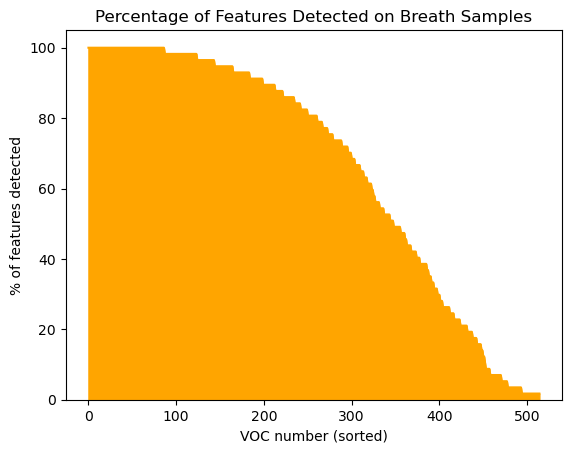

In [260]:
omni_df_ss_na = omni_df_breath_filtered.notna().sum().sort_values(ascending=False).reset_index(
    drop=True)*100/len(omni_df_breath_filtered)
omni_df_ss_na.plot(kind='area', color='orange')
plt.title('Percentage of Features Detected on Breath Samples')
plt.ylabel('% of features detected')
plt.xlabel('VOC number (sorted)')
plt.show()

Over 350 VOCs appear 50% of the time after filtering.

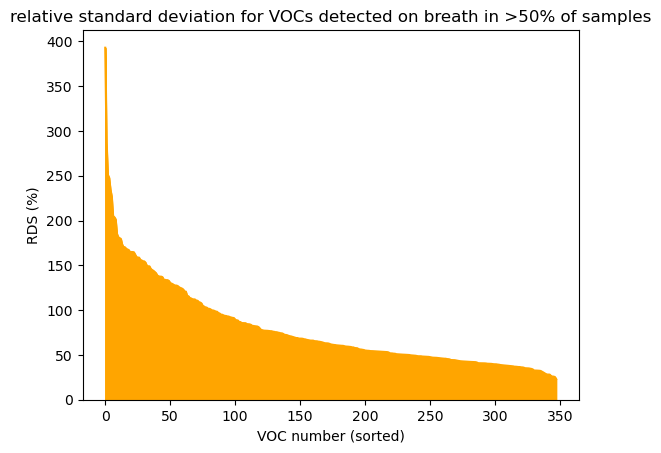

In [261]:
# calculate % of not na values per feature
omni_df_ss_na2 = omni_df_breath_filtered.notna().sum()*100 / \
    len(omni_df_breath_filtered)
# get features with more than 50%
omni_df_ss_na2 = omni_df_ss_na2[omni_df_ss_na2 >= 50].reset_index()
# drop features with less than 50%
omni_df_ss_rsd = omni_df_breath_filtered[omni_df_breath_filtered.columns[omni_df_breath_filtered.columns.isin(
    omni_df_ss_na2['index'])]]
# calculate relative standard deviation (RSD).
omni_df_ss_rsd_C = omni_df_ss_rsd.std(
    skipna=True)*100/omni_df_ss_rsd.mean(skipna=True)
# sort and plot
omni_df_ss_rsd_C = omni_df_ss_rsd_C.sort_values(
    ascending=False).reset_index(drop=True)
omni_df_ss_rsd_C.plot(kind='area', color='orange')
plt.title(
    'relative standard deviation for VOCs detected on breath in >50% of samples')
plt.ylabel('RDS (%)')
plt.xlabel('VOC number (sorted)')
plt.show()

In [262]:
print("The median inter-subject RSD across these VOCs was {}".format(omni_df_ss_rsd_C.median()))

The median inter-subject RSD across these VOCs was 61.841038512808936


## Pulmonary Disease Dataset

Data extracted from https://www.nature.com/articles/s41597-024-03052-2#Sec9

### Load data

In [263]:
# load csv files
asthma_df = pd.read_csv(

    'Data/pulmonary/Asthma_peaktable_ver3.csv').transpose().reset_index()

# formatting: remove first two rows and rename, and label ID

asthma_df.columns = asthma_df.iloc[1]

asthma_df.drop([0, 1], axis=0, inplace=True)

asthma_df.reset_index(inplace=True, drop=True)

asthma_df['IUPAC Name'] = asthma_df['IUPAC Name'].astype(
    int).astype(str)+str('-Asthma')
bronchi_df = pd.read_csv(

    'Data/pulmonary/Bronchi_peaktable_ver3.csv').transpose().reset_index()

# formatting: remove first two rows and rename, and label ID

bronchi_df.columns = bronchi_df.iloc[1]

bronchi_df.drop([0, 1], axis=0, inplace=True)

bronchi_df.reset_index(inplace=True, drop=True)

bronchi_df['IUPAC Name'] = bronchi_df['IUPAC Name'].astype(
    int).astype(str)+str('-Bronchiectasis')

COPD_df = pd.read_csv(

    'Data/pulmonary/COPD_peaktable_ver3.csv').transpose().reset_index()

# formatting: remove first two rows and rename, and label ID

COPD_df.columns = COPD_df.iloc[1]

COPD_df.drop([0, 1], axis=0, inplace=True)

COPD_df.reset_index(inplace=True, drop=True)

COPD_df['IUPAC Name'] = COPD_df['IUPAC Name'].astype(
    int).astype(str)+str('-COPD')

In [264]:
# load excel filesp
patient_data_df = pd.concat(pd.read_excel(
    'Data/pulmonary/CBD_metadata_for_ver3.xlsx', sheet_name=None), ignore_index=True)
patient_data_df.head()

,ID,Disease,ACT,CAT,sex,age,FVC PP,FEV10 PP,BH (cm),BW (kg),BMI
0,1,Asthma,25.0,NaN,M,46.0,82.74,67.09,175.0,79.0,25.795918
1,2,Asthma,22.0,NaN,M,38.0,120.99,102.11,175.0,66.0,21.551020
2,3,Asthma,23.0,NaN,F,75.0,72.19,49.81,149.5,46.6,20.849879
3,4,Asthma,17.0,NaN,F,44.0,NaN,NaN,156.0,53.2,21.860618
4,5,Asthma,16.0,NaN,F,79.0,89.60,123.80,170.0,70.0,24.221453


In [265]:
# see nans per column
patient_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        121 non-null    int64  
 1   Disease   121 non-null    object 
 2   ACT       53 non-null     float64
 3   CAT       33 non-null     float64
 4   sex       121 non-null    object 
 5   age       120 non-null    float64
 6   FVC PP    81 non-null     float64
 7   FEV10 PP  81 non-null     float64
 8   BH (cm)   97 non-null     float64
 9   BW (kg)   98 non-null     float64
 10  BMI       95 non-null     float64
dtypes: float64(8), int64(1), object(2)
memory usage: 10.5+ KB


### Impute per Disease

In [266]:
# sort index
patient_data_df = patient_data_df.reindex(
    columns=sorted(patient_data_df.columns))
# collector
gc = []
# loop over diseases
for dis in patient_data_df['Disease'].unique():
    # create holders
    other_columns = []
    numeric_columns = []
    subset_df = patient_data_df[patient_data_df['Disease'] == dis]
    # loop over columns that are numeric and have at least 1 non nan value
    for c in subset_df.columns:
        if (c in subset_df.select_dtypes(include='number')) & (subset_df[c].isna().sum() < len(subset_df)):
            numeric_columns.append(c)
        else:
            other_columns.append(c)
    data_numeric = subset_df[numeric_columns]
    data_categorical = pd.DataFrame(subset_df[other_columns])
    # impute numeric
    imp = IterativeImputer(max_iter=10, random_state=0)
    data_numeric = pd.DataFrame(imp.fit_transform(data_numeric),
                                columns=data_numeric.columns,
                                index=data_numeric.index)
    # merge back
    data_joined = pd.concat([data_categorical, data_numeric], axis=1)
    # reorder columns
    data_joined = data_joined.reindex(columns=sorted(patient_data_df.columns))
    gc.append(data_joined)
# merge loop data
patient_data_df_imputed = pd.concat(gc)

c:\Users\mifab\anaconda3\envs\pytorch24\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\mifab\anaconda3\envs\pytorch24\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
c:\Users\mifab\anaconda3\envs\pytorch24\lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Combine Dataframes

In [267]:
# create matching ID column
patient_data_df_imputed['IUPAC Name'] = patient_data_df_imputed['ID'].astype(int).astype(str) + \
    str('-') + patient_data_df_imputed['Disease'].astype(str)
# move to front

col = patient_data_df_imputed.pop("IUPAC Name")
patient_data_df_imputed.insert(0, col.name, col)

# drop old tags
patient_data_df_imputed.drop(['ID'], axis=1, inplace=True)

# remove duplicate columns in COPD_df
COPD_df = COPD_df.loc[:, ~COPD_df.columns.duplicated(keep='first')]

# combine all disease csv from folder
disease_combined = pd.concat([bronchi_df, asthma_df, COPD_df])

num_cols = disease_combined.columns.difference(['IUPAC Name'])

disease_combined[num_cols] = disease_combined[num_cols].apply(
    pd.to_numeric, errors='coerce')

# combine with patient data via join

combined_respiratory_dataset = pd.merge(
    patient_data_df_imputed, disease_combined, on='IUPAC Name')
combined_respiratory_dataset.head()

# remove columns with nans, as they are VODs that are not present in all diseases and will bias ML model
X_Y_dataset = combined_respiratory_dataset[combined_respiratory_dataset.columns[~combined_respiratory_dataset.isna(
).any()]]

X_Y_dataset.head()

,IUPAC Name,BH (cm),BMI,BW (kg),Disease,FEV10 PP,FVC PP,age,sex,2-(4-methylcyclohex-3-en-1-yl)propan-2-ol,...,N-methyl-N-[2-(methylamino)ethyl]benzamide,5-ethyl-2-methyloctane,"4-(2,4,4-trimethylpentan-2-yl)phenol",trimethyl-[2-trimethylsilyloxy-1-(4-trimethylsilyloxyphenyl)ethoxy]silane,1-phenylpropan-1-ol,4-O-[2-(2-chlorophenoxy)ethyl] 1-O-ethyl butanedioate,4-methyl-1-propan-2-ylcyclohex-3-en-1-ol,tridecane,tris(2-methylpropyl) phosphate,undecane
0,1-Asthma,175.0,25.795918,79.0,Asthma,67.090000,82.740000,46.0,M,25171.0,...,97420.0,2694.246,19271.0,63154.0,87788.13,9492.295,37270.80,21707.0,72875.0,281444.0
1,2-Asthma,175.0,21.551020,66.0,Asthma,102.110000,120.990000,38.0,M,35426.0,...,159891.0,5271.946,10098.0,163957.0,162142.00,30837.000,71895.00,24692.0,109772.0,432542.1
2,3-Asthma,149.5,20.849879,46.6,Asthma,49.810000,72.190000,75.0,F,34209.0,...,110765.0,4351.000,14218.0,81069.0,141013.00,28959.000,39959.00,13369.0,113515.0,378186.0
3,4-Asthma,156.0,21.860618,53.2,Asthma,77.135858,88.005255,44.0,F,21397.0,...,165803.0,3073.000,6313.0,54720.0,84522.00,9275.080,40154.00,15689.0,66902.0,294211.0
4,5-Asthma,170.0,24.221453,70.0,Asthma,123.800000,89.600000,79.0,F,214153.0,...,19903.0,3366.000,7415.0,95460.0,38297.00,1541.204,32188.99,17069.0,62604.0,266129.0


In [268]:
print("The dataset is now constructed with {} samples and {} features".format(
    X_Y_dataset.shape[0], X_Y_dataset.shape[1]))

The dataset is now constructed with 121 samples and 82 features


### Exploratory data analysis

<Axes: title={'center': 'Class distribution'}, ylabel='Disease'>

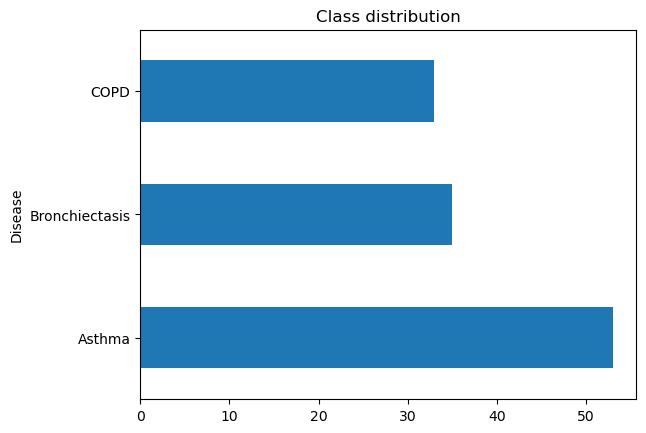

In [269]:
# class distribution
X_Y_dataset['Disease'].value_counts().plot(
    kind='barh', title='Class distribution')

there are more asthma patients than COPD and Bronchiectasis.

Text(0.5, 1.0, 'Age distribution by disease')

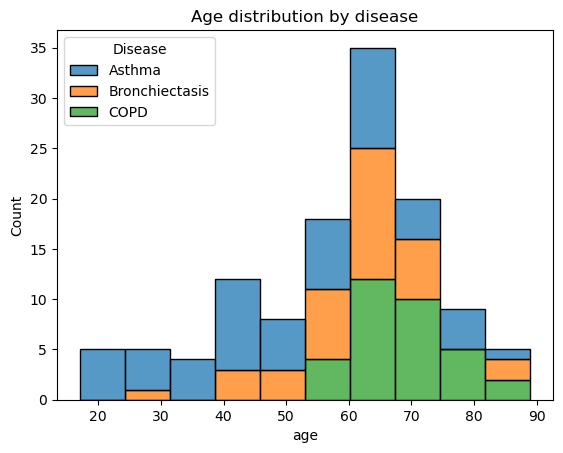

In [270]:
sns.histplot(data=X_Y_dataset, x="age", hue="Disease", multiple="stack")
plt.title('Age distribution by disease')

Asthma has the widest age distribution,

COPD has the smallest age distribution and is in older people only,

Bromchondriasis appears to be spread across randomly.

The most frequent age range is between 60 and 70.

Text(0.5, 1.0, 'BH (cm) distribution by disease')

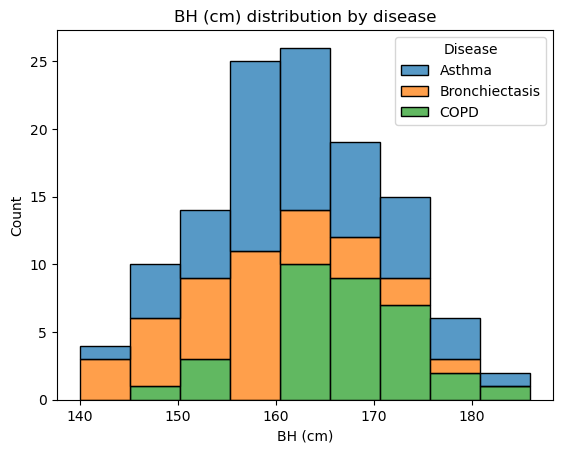

In [271]:
sns.histplot(data=X_Y_dataset, x="BH (cm)", hue="Disease", multiple="stack")
plt.title('BH (cm) distribution by disease')

BH (cm) appears to be normally distributed, with most people being around 160 cm.

Text(0.5, 1.0, 'BMI distribution by disease')

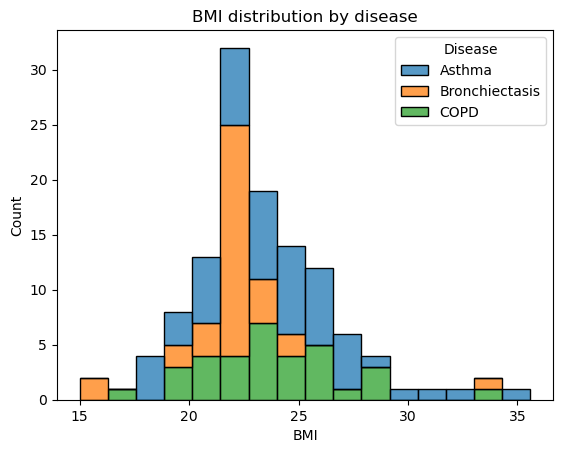

In [272]:
sns.histplot(data=X_Y_dataset, x="BMI", hue="Disease", multiple="stack")
plt.title('BMI distribution by disease')


BMI of asthmatics has the widest distribution.

BMI of Bronchiectasis is predominantly in the 22-23 range, with outliers at both ends.

BMI of COPD has a smaller distribution range. 

Text(0.5, 1.0, 'BW (kg) distribution by disease')

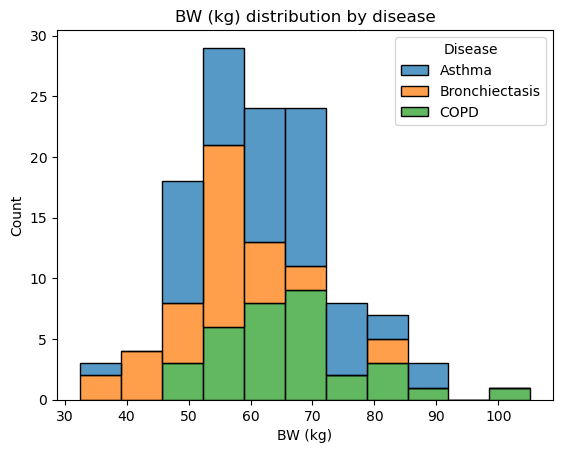

In [273]:
sns.histplot(data=X_Y_dataset, x="BW (kg)", hue="Disease", multiple="stack")
plt.title('BW (kg) distribution by disease')


BW of asthmatics has the widest distribution.

BW of Bronchiectasis is predominantly in the 55-60 range, and overall in the lower-end of the spectrum.

BW of COPD is in the higher end of the distribution.

Text(0.5, 1.0, 'FEV10 PP distribution by disease')

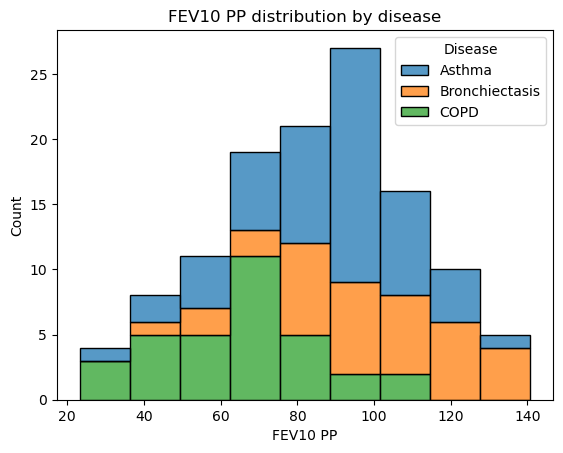

In [274]:
sns.histplot(data=X_Y_dataset, x="FEV10 PP", hue="Disease", multiple="stack")
plt.title('FEV10 PP distribution by disease')

Text(0.5, 1.0, 'FVC PP distribution by disease')

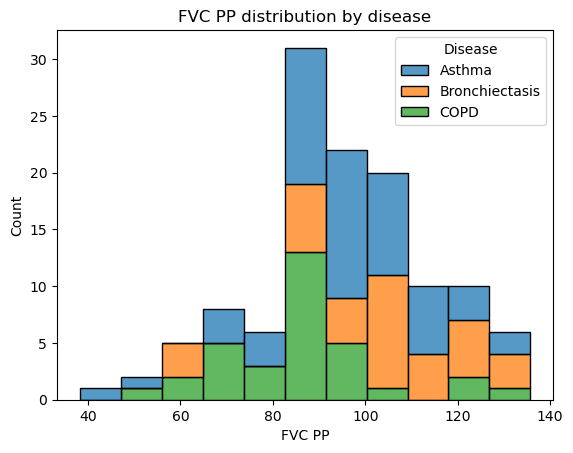

In [275]:
sns.histplot(data=X_Y_dataset, x="FVC PP", hue="Disease", multiple="stack")
plt.title('FVC PP distribution by disease')

<Axes: xlabel='Disease', ylabel='count'>

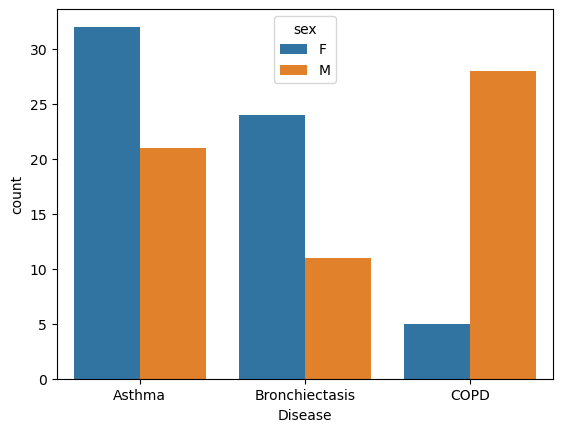

In [276]:
sex_sf = X_Y_dataset['sex'].groupby(
    X_Y_dataset['Disease']).value_counts().reset_index()
sns.barplot(data=sex_sf, x="Disease", y="count", hue="sex")

### Machine Learning Classification

#### Prepare data and models

In [277]:
X_Y_dataset = X_Y_dataset.drop('IUPAC Name', axis=1)  # drop IUPAC Name
X_Y_dataset['sex'] = X_Y_dataset['sex'].map(
    {'M': 0, 'F': 1})  # map sex to numbers

le = LabelEncoder()
X_Y_dataset['Disease'] = le.fit_transform(X_Y_dataset['Disease'])

# Create X and y dataframes
X = X_Y_dataset.loc[:, X_Y_dataset.columns != "Disease"]
y = X_Y_dataset.loc[:, X_Y_dataset.columns == "Disease"]

# models that will be trained on the data
models = {
    # "Logistic Regression": LogisticRegression(random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0),
    "K-Nearest Neighbours": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC()
}

# create holders
model_df = []
accuracy = []
f1 = []

# create kfold
kf = KFold(n_splits=10)

#### Train and test models

In [278]:
for train, test in kf.split(X_Y_dataset):

    X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test]

    for model, model_launch in models.items():

        # Loop through listed models
        model_initiated = model_launch
        model_initiated.fit(X_train, y_train.values.ravel())
        predictions = model_initiated.predict(X_test)

        # Model Names
        model_df.append(model)

        # Model Scores
        accuracy.append(accuracy_score(y_test, predictions))

scores_df_stand = pd.DataFrame({'Model': model_df,
                                'Accuracy': accuracy
                                })

#### Get Scores

In [279]:
scores_df_stand_g = scores_df_stand.groupby(by='Model').mean().sort_values(
    by='Accuracy', ascending=False).reset_index(drop=False)

scores_df_stand_g

(scores_df_stand_g.style
 .background_gradient(subset=['Accuracy'])
 .highlight_max(subset=['Accuracy'], color='gold')
 .set_caption('Model Performance 10 k-fold cross validation')
 .format({'Accuracy': "{:.2%}"
          }))

,Model,Accuracy
0,Decision Tree,87.50%
1,Random Forest,87.50%
2,Gradient Boosting,85.00%
3,K-Nearest Neighbours,39.23%
4,SVM,25.00%


### Feature Importance with SHAP

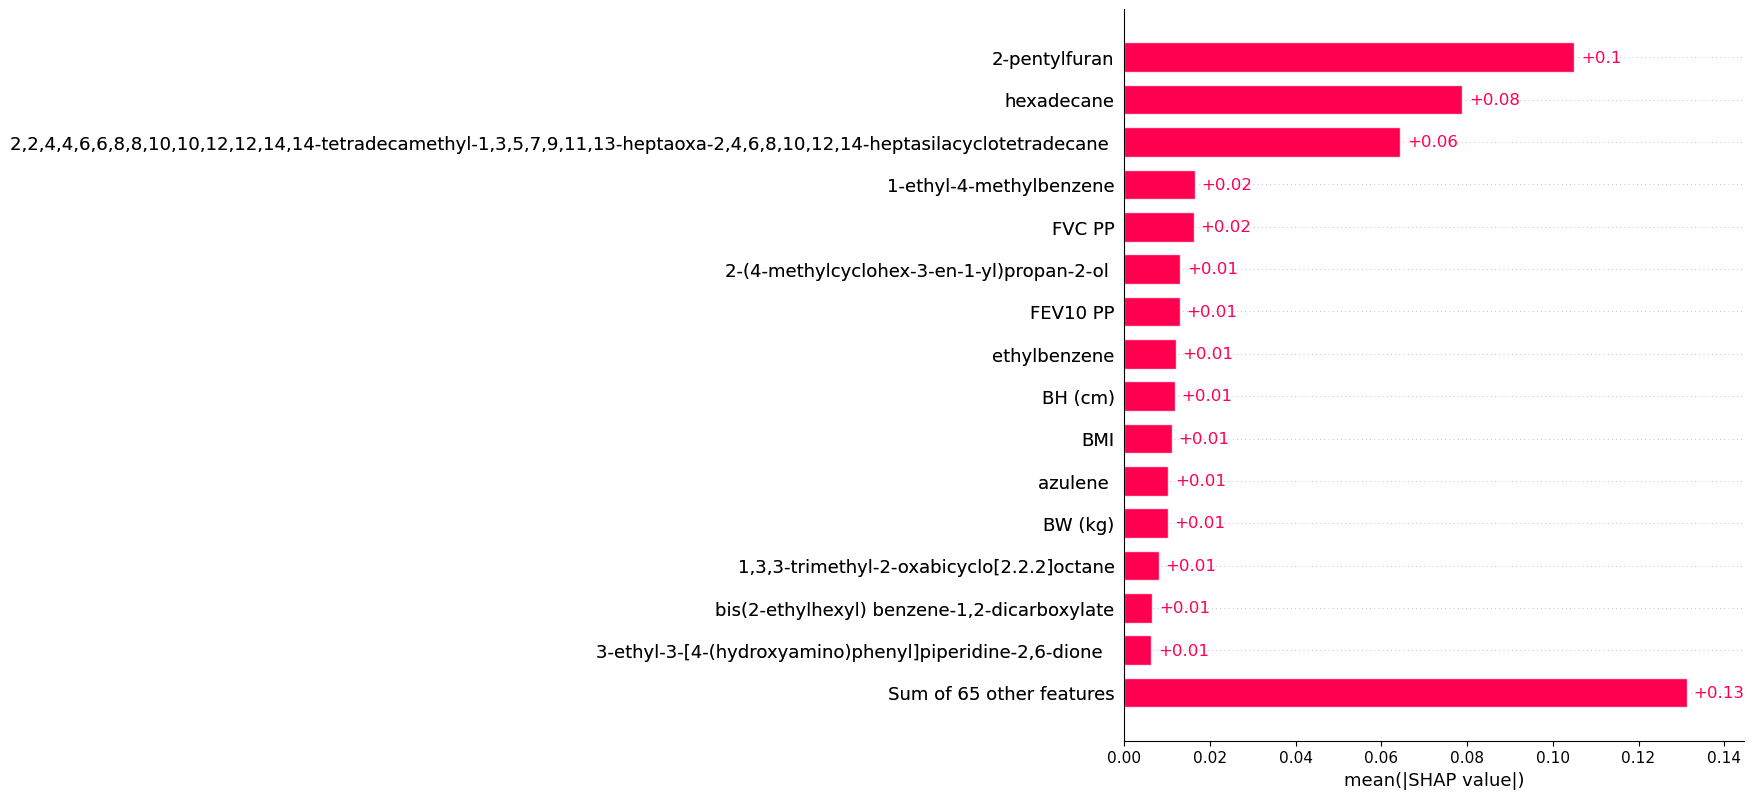

In [280]:
# create a model, fit it and create an explainer
clf3 = models['Random Forest']
clf3.fit(X_train, y_train.values.ravel())
explainer = shap.TreeExplainer(clf3, X_train)
shap_values = explainer(X_train)
# plot 20% of the most important features
shap.plots.bar(shap_values[:, :, 1], max_display=16)